### **PINN eikonal based velocity inversion for crosshole tomopgraph of the SEAM model**

In [1]:
'''
@Time    :   2025/03/03 17:20:43
@Author  :   ShaoboYang
@Email   :   yang0123@mail.ustc.edu.cn
'''

import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import time
import random
import os 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sph2car import sph2car_ft

device = 'cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model_path = 'models'
fig_path = 'figs'
os.system(f'mkdir {model_path} {fig_path}')

256

In [2]:
#Model specifications

# Computational model parameters
wlat_ft = 36.65; wlon_ft = 119.18; theta_ft = 0
ymin = -40.; ymax = 40.; deltay_pred = 1
xmin = -60.; xmax = 60.; deltax_pred = 1 

In [3]:
T_inp = np.round(np.arange(0.6, 10+0.01, 0.2), decimals=2)
nT_inp = T_inp.size

In [4]:
# create input and target data
# data points and boundary condition

vs_ini = 2.6

T0 = []
T_data = []
tau0 = []
data = []            ## rz, rx, sz, sx, pz, px, T0, tau, v, t
sx = []
sy = []
with open('data_2s.dat', 'r') as f:
    for line in f.readlines():
        if line[0] == '#':
            items = line.split()
            evla0 = float(items[1])
            evlo0 = float(items[2])
            T_index = int(items[3])
            if T_index == 8:
                sx0, sy0, sz0 = sph2car_ft(evla0, evlo0, 0, wlat_ft, wlon_ft, theta_ft)
                if sx0 not in sx or sy0 not in sy:
                    sx.append(sx0)
                    sy.append(sy0)
                sv = vs_ini
                data.append([sy0, sx0, sy0, sx0, T_inp[T_index], 0, 0, 0, 1, sv, 0])
                data.append([sy0, sx0, sy0, sx0, T_inp[T_index], 0, 0, 0, 1, sv, 0])
        elif T_index == 8:
            stla0, stlo0, phasev = line.split()
            stla0 = float(stla0)
            stlo0 = float(stlo0)
            rx0, ry0, rz0 = sph2car_ft(stla0, stlo0, 0, wlat_ft, wlon_ft, theta_ft)
            dist = ((ry0 - sy0)**2 + (rx0 - sx0)**2)**0.5
            T_data0 = dist/float(phasev)
            T_data.append(T_data0)
            T00 = dist/sv
            # print(T_data0, T00, sy0, ry0, sx0, rx0)
            T0.append(T00)
            px0 = (rx0 - sx0)/T00/sv**2
            py0 = (ry0 - sy0)/T00/sv**2
            tau00 = T_data0/T00
            tau0.append(tau00)
            data.append([ry0, rx0, sy0, sx0, T_inp[T_index], py0, px0, T00, tau00, sv, T_data0])
            data.append([sy0, sx0, ry0, rx0, T_inp[T_index], -py0, -px0, T00, tau00, sv, T_data0])

T0 = np.array([T0])
T_data = np.array([T_data])
tau0 = np.array([tau0])
data = np.array(data)
T0 = T0.transpose(1, 0)
T_data = T_data.transpose(1, 0)
tau0 = tau0.transpose(1, 0)
ns = len(sx)
# data = data.transpose(1, 0)

print(T_data.shape, T0.shape, tau0.shape)
print(data.shape)      # 11*11*52: features, n_event, n_reveiver
print(ns)

(13549, 1) (13549, 1) (13549, 1)
(27680, 11)
291


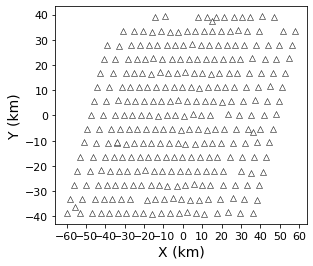

In [5]:
# Plot the source location

plt.style.use('default')

plt.figure(figsize=(4.5,4))

ax = plt.gca()
# im = ax.pcolor(x_pred, y_pred, vel, shading='auto', cmap="jet_r")
ax.plot(sx, sy, 'k^', markersize=6, markerfacecolor='w', markeredgewidth='0.5')
# ax.plot(sx, sy, 'y*', markersize=10)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=11)

# plt.gca().invert_yaxis()

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))


plt.savefig(f"./{fig_path}/sta.pdf", format='pdf', bbox_inches="tight")

In [7]:
# create constrant on each grid using eikonal equation (ekl)
# points of PDE residual 

from pyDOE import lhs 

def random_pde_points(n_points, ns):
    T0_all = np.zeros((n_points, ns))
    px0_all = np.zeros((n_points, ns))
    pz0_all = np.zeros((n_points, ns))
    ekl_data = []
    for k in range(ns):
        for l in range(nT_inp):
            if l == 8:
                random_p = lhs(2, n_points)
                x = random_p[:, 0]*(xmax-xmin) + xmin
                y = random_p[:, 1]*(ymax-ymin) + ymin
                T0_all[:, k] = np.sqrt((sy[k]-y)**2 + (sx[k]-x)**2)/vs_ini
                index = np.where(T0_all[:, k] != 0)
                px0_all[index, k] = (x - sx[k])/T0_all[index, k]/vs_ini**2
                pz0_all[index, k] = (y - sy[k])/T0_all[index, k]/vs_ini**2
                ekl_data.append(np.array([y, x, sy[k]*np.ones(n_points), sx[k]*np.ones(n_points), T_inp[l]*np.ones(n_points), 
                                    pz0_all[:, k], px0_all[:, k], T0_all[:, k], vs_ini*np.ones(n_points)]))
    ekl_data = np.array(ekl_data)
    ekl_data = ekl_data.transpose((2, 0, 1))
    return T0_all, px0_all, pz0_all, ekl_data 
print(ns)
n_points = 10000
T0_all, px0_all, pz0_all, ekl_data = random_pde_points(n_points, ns)
# print(T0_all.shape, px0_all.shape, pz0_all.shape, ekl_data.shape)            # (10000, 11, 9)

291


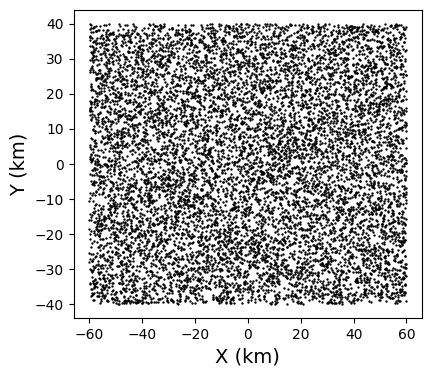

In [8]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4.5,4))

ax = plt.gca()
# im = ax.imshow(T_data_all[:,:,0], extent=[xmin,xmax,ymax,ymin], aspect=1, cmap="jet_r")
ax.scatter(ekl_data[:,0,1], ekl_data[:,0,0], marker='.', c='k', s=2)

plt.xlabel('X (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Y (km)', fontsize=14)
plt.yticks(fontsize=10)

# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)

In [9]:
import math
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable, grad
from torch.cuda.amp import autocast
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler

def init_weights(m):
    if type(m) == torch.nn.Linear:
        stdv = (1. / math.sqrt(m.weight.size(1))/1.)*2        # m.weight.size(1) = 20 if nl = 10
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

def init_weights2(m):             # glorot_uniform 
    if type(m) == torch.nn.Linear: 
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)


/home/yang/Softwares/Anaconda3/envs/sciann/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(1234)

In [11]:
class NN_t(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
    # def __init__(self, nl=10, activation=torch.nn.ELU()):
            super(NN_t, self).__init__()
            self.act = activation
            self.sigmoid = torch.nn.Sigmoid()

            # Input Structure
            self.fc_t0  = Linear(5, 100)

            # Resnet Block
            self.fc_list_t = torch.nn.ModuleList([Linear(100, 100) for i in range(nl)])

            # Output structure
            self.fc_t1  = Linear(100, 1)

    def forward(self, xt):
        xt = self.act(self.fc_t0(xt))
        for i in range(len(self.fc_list_t)):
            xt = self.act(self.fc_list_t[i](xt))

        # tau = 5*self.sigmoid(self.fc_t1(xt))
        tau = self.act(self.fc_t1(xt))
        return tau

class NN_v(torch.nn.Module):
    def __init__(self, nl=10, activation=torch.nn.LeakyReLU()):
        super(NN_v, self).__init__()
        self.act = activation
        self.sigmoid = torch.nn.Sigmoid()

        # Input Structure
        self.fc_v0  = Linear(3, 50)

        # Resnet Block
        self.fc_list_v = torch.nn.ModuleList([Linear(50, 50) for i in range(nl)])

        # Output structure
        self.fc_v1  = Linear(50, 1)

    def forward(self, xv):
        xv = self.act(self.fc_v0(xv))
        for i in range(len(self.fc_list_v)):
            xv = self.act(self.fc_list_v[i](xv))

        v_iso = 5*self.sigmoid(self.fc_v1(xv))
        
        # v = 5*self.act(self.fc_v1(xv))
        return v_iso

# Data: [rz[j], rx[j], sz[i], sx[i], pz0[i, j], px0[i, j], T0[i, j], tau0[i, j], vs[i]])
# pair_loc: [rz, rx, sz, sx]
# factors: [pz0, px0, T0]
# st_loc: [rz, rx]

def PDELoss2(pair_loc, factors, tau_pred, v_iso_pred, device):
    dtau  = torch.autograd.grad(outputs=tau_pred, inputs=pair_loc, grad_outputs=torch.ones(tau_pred.size()).to(device), 
                        only_inputs=True, create_graph=True, retain_graph=True)[0]
    pz0 = torch.unsqueeze(factors[:, 0], dim=1)
    px0 = torch.unsqueeze(factors[:, 1], dim=1)
    T0 = torch.unsqueeze(factors[:, 2], dim=1)
    dtau_drz = torch.unsqueeze(dtau[:, 0], dim=1)
    dtau_drx = torch.unsqueeze(dtau[:, 1], dim=1)

    v_pred = v_iso_pred
    s_eikonal = dtau_drz**2 + dtau_drx**2
    s_pred = 1.0/v_pred**2
    pde_loss = F.mse_loss(s_eikonal, s_pred)
    loss = pde_loss
    return loss

###  without PDE loss ###
def DataLoss2(tau_pred, tau_obs, device):       
    t_loss = F.mse_loss(tau_pred, tau_obs)
    # loss_t = (torch.sum((tau_pred - tau_obs)**2)/len(tau_obs))**0.5
    loss = t_loss
    return loss


In [12]:
T0_all = T0_all.reshape(-1, 1)
ekl_data = ekl_data.reshape(-1, 9, 1)
# ekl_data = ekl_data.transpose(1, 0, 2)
ekl_data = ekl_data[:, :8, 0]
print(ekl_data.shape, T0_all.shape)
# print(ekl_data[100:110])

# data = data[:, :8]
print(data.shape)

# print(data[100:120])

(2910000, 8) (2910000, 1)
(27680, 11)


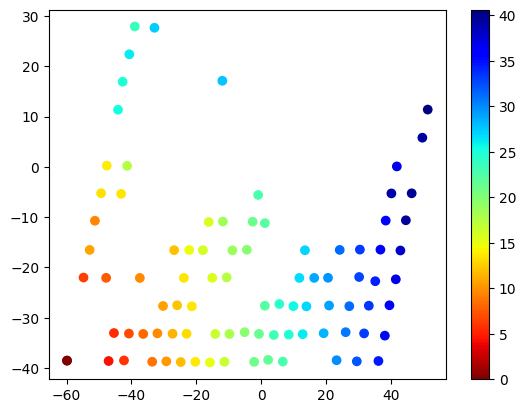

In [13]:
# print(np.where(data[:, 2]==0))
np.set_printoptions(threshold=np.inf)
part = data[np.where((data[:, 2]==sy[0])&(data[:, 3]==sx[0]))]
# print(part)
data_array = np.concatenate((part[:, :2], part[:, 8:11]), axis=1)
# print(data_array)


colormap = plt.cm.get_cmap('jet_r') # 使用'viridis'颜色映射

# 绘制散点图
plt.scatter(data_array[:, 1], data_array[:, 0], c=data_array[:, 4], cmap=colormap)

# 添加颜色条
plt.colorbar()

# 显示图形
plt.show()

In [14]:
nn_t = NN_t()
nn_t.apply(init_weights2)
nn_t.float()
nn_t.to(torch.device(device=device))

nn_v = NN_v()
nn_v.apply(init_weights2)
nn_v.float()
nn_v.to(torch.device(device=device))

# pred_grid = torch.from_numpy(pred_grid.astype(np.float32)).cuda()
# v_ini, dan1_ini, dan2_ini  = nn_v.forward(pred_grid)

# Data: [rz[j], rx[j], sz[i], sx[i], pz0[i, j], px0[i, j], T0[i, j], tau0[i, j], vs[i]])
tmp = torch.from_numpy(np.linspace(0, 1, len(ekl_data)))
tmp = torch.unsqueeze(tmp, dim=1)
ekl_data_tensor = torch.from_numpy(ekl_data.astype(np.float32))
ekl_dataset = torch.utils.data.TensorDataset(ekl_data_tensor, tmp)

tmp2 = torch.from_numpy(np.linspace(0, 1, len(data)))
tmp2 = torch.unsqueeze(tmp2, dim=1)
data_tensor = torch.from_numpy(data.astype(np.float32))
obs_dataset = torch.utils.data.TensorDataset(data_tensor, tmp2)
print(f'PDE points: {len(ekl_data_tensor)}, Data points: {len(data_tensor)}')


########### Train #############
from itertools import chain 
# optimizer = torch.optim.Adam(chain(nn_t.parameters(), nn_v.parameters()), lr=0.001)
optimizer = torch.optim.Adam([{'params': nn_t.parameters(), 'lr': 0.0005},
                              {'params': nn_v.parameters(), 'lr': 0.0005}])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epoch_num = 200
ekl_batch_size = 1024
# ekl_batch_size = len(ekl_dataset)
obs_batch_size = 128
ntk_freq = 10
# obs_batch_size = len(obs_dataset)
loss_all = []
pde_loss_all = []
data_loss_all = []
ntk_all = {'sum':[], 'pde':[], 'data':[]}
for epoch in range(epoch_num):
    ekl_data_loader = torch.utils.data.DataLoader(dataset=ekl_dataset, batch_size=ekl_batch_size, shuffle=True)
    obs_data_loader = torch.utils.data.DataLoader(dataset=obs_dataset, batch_size=obs_batch_size, shuffle=True)
    obs_data_iter = iter(obs_data_loader)
    for i, ekl_data_batch in enumerate(ekl_data_loader):
        ekl_data_batch = ekl_data_batch[0]
        ekl_pair_loc_batch = ekl_data_batch[:, :5].cuda()
        ekl_factors_batch = ekl_data_batch[:, 5:8].cuda()

        ekl_pair_loc_batch.requires_grad_()
        ekl_tau_pred = nn_t.forward(ekl_pair_loc_batch)

        st_loc_batch = ekl_data_batch[:, [0,1,4]].cuda()
        ekl_v_pred = nn_v.forward(st_loc_batch)
        pde_loss = PDELoss2(ekl_pair_loc_batch, ekl_factors_batch, ekl_tau_pred, ekl_v_pred, device)
        try:
            obs_data_batch = next(obs_data_iter)
        except StopIteration:
            obs_data_loader = torch.utils.data.DataLoader(dataset=obs_dataset, batch_size=obs_batch_size, shuffle=True)
            obs_data_iter = iter(obs_data_loader)
            obs_data_batch = next(obs_data_iter)

        obs_data_batch = obs_data_batch[0].cuda()
        obs_pair_loc_batch = obs_data_batch[:, :5]

        # obs_pair_loc_batch.requires_grad_()
        obs_tau_batch = obs_data_batch[:, 10].unsqueeze(dim=1)

        pred_tau = nn_t.forward(obs_pair_loc_batch)
        data_loss = DataLoss2(pred_tau, obs_tau_batch, device=device)

        weighted_loss = data_loss*0.4 + pde_loss
        # weighted_loss = data_loss
        true_loss = data_loss.cpu().detach().numpy() + pde_loss.cpu().detach().numpy()

        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        
        # del 

    lr_scheduler.step()
    print(f'Epoch {epoch+1}, loss = {true_loss:.4e}; PDE loss = {pde_loss.item():.4e}; data loss = {data_loss.item():.4e};', 
          'lr1 = {}; lr2 = {};'.format(optimizer.param_groups[0]['lr'], optimizer.param_groups[1]['lr']))

    loss_all.append(true_loss.item())
    pde_loss_all.append(pde_loss.item())
    data_loss_all.append(data_loss.item())

    if (epoch+1)%10 == 0:
        torch.save(nn_v, f'./{model_path}/{epoch+1}_v.pt')
        torch.save(nn_t, f'./{model_path}/{epoch+1}_t.pt')
        
    # break

# Convergence history plot for verification
fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(list(range(epoch_num)), loss_all, linewidth=2, label='Sum')
ax.semilogy(list(range(epoch_num)), pde_loss_all, linewidth=2, label='PDE')
ax.semilogy(list(range(epoch_num)), data_loss_all, linewidth=2, label='Data')
plt.legend()

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)
plt.grid()


PDE points: 2910000, Data points: 27680
Epoch 1, loss = 1.2465e+00; PDE loss = 3.9785e-03; data loss = 1.2425e+00; lr1 = 0.0005; lr2 = 0.0005;
Epoch 2, loss = 7.0412e-01; PDE loss = 4.9856e-03; data loss = 6.9914e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 3, loss = 4.8623e-01; PDE loss = 8.7389e-03; data loss = 4.7749e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 4, loss = 6.2895e-01; PDE loss = 8.2319e-03; data loss = 6.2072e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 5, loss = 4.5888e-01; PDE loss = 6.7596e-03; data loss = 4.5212e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 6, loss = 8.0523e-01; PDE loss = 6.0562e-03; data loss = 7.9917e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 7, loss = 4.4023e-01; PDE loss = 4.1977e-03; data loss = 4.3604e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 8, loss = 3.2439e-01; PDE loss = 6.6855e-03; data loss = 3.1770e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 9, loss = 3.5212e-01; PDE loss = 1.0201e-02; data loss = 3.4192e-01; lr1 = 0.0005; lr2 = 0.0005;
Epoch 10, loss = 6.6426e-01; PDE 

KeyboardInterrupt: 

In [ ]:
# np.savetxt(f'./{model_path}/ntk_obs', ntk_all['data'])
# np.savetxt(f'./{model_path}/ntk_pde', ntk_all['pde'])
np.savetxt(f'./{model_path}/loss_all', loss_all)
np.savetxt(f'./{model_path}/pde_loss_all', pde_loss_all)
np.savetxt(f'./{model_path}/data_loss_all', data_loss_all)